<a href="https://colab.research.google.com/github/bdlttp/CS5300Public/blob/main/Phase5Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS5300 UMSL Artificial Inteligence
### Semester-long Project  Phase 5 Notebook
#### Brian Lindemann December, 2021

This is the final notebook.

In [ ]:
# standard setup stuff to get environment correct
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "" # turn off GPU support
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  fn_pre = "/content/drive/My Drive/Colab Notebooks/"
else:
  fn_pre = ""

import tensorflow as tf
print(tf.config.list_physical_devices())

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score,accuracy_score
from matplotlib.pylab import rcParams
''' 
The first time tensorflow is imported, there is a bunch of verbose information about whether it is 
using CUDA cores, how many, which, whether it is using NUMA, etc. 
Subsequent times there is no information printed out.
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
np.set_printoptions(formatter={'float':'{: 0.2f}'.format})
#import tensorflow as tf
print(tf.config.list_physical_devices())
num_cores = 4
num_CPU = 4
num_GPU = 0
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
#                        inter_op_parallelism_threads=num_cores, 
#                        allow_soft_placement=True,
#                        device_count = {'CPU' : num_CPU,
#                                        'GPU' : num_GPU}
#                       )

Mounted at /content/drive
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Get the data from the data source. For this project I have chosen the TV_News_Channel_commercial_Detection_Dataset from  
https://archive.ics.uci.edu/ml/machine-learning-databases/00326/TV_News_Channel_Commercial_Detection_Dataset.zip  
This dataset is broken into 5 files of text data - one for each of 5 international news stations - which must be pre-processed to make the csv file that is imported into this file. For the first phase of the project, I am only using the data from TIMESNOW. The full dataset is 129,685 records long, which I plan to use for the full project, but the TIMESNOW dataset is only . 
I am also stripping the attributes down to 19 of interest - leaving out the items that would utilize text recoginition. This step will determine whether or not those 19 will work for this classification project.

The data in "SL" - or Shot Length - is wildly large at times and nominally small. The shot length appears to be the duration of the clip being looked at by human to determine whether it is a commercial or not. In final analysis, the durationof a clip should not be considered as an indicator of whether the shot is a commercial or not.

Also, note that the mean for "Commercial" is .64 - which means that there are 64% Commercials ("Advertisements"), and 46% "News".

In [ ]:
TimesNowData = np.genfromtxt(fn_pre+"TIMESNOW.csv",delimiter=",",skip_header=True,usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))
CNNData = np.genfromtxt(fn_pre+"CNN.csv",delimiter=",",skip_header=True,usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))
BBCData = np.genfromtxt(fn_pre+"BBC.csv",delimiter=",",skip_header=True,usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))
CNNIBNData = np.genfromtxt(fn_pre+"CNNIBN.csv",delimiter=",",skip_header=True,usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))
NDTVData = np.genfromtxt(fn_pre+"NDTV.csv",delimiter=",",skip_header=True,usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))

ColNames = ["MD-M","MD-V","FDD-M","FDD-V","STE-M","STE-V","ZCR-M","ZCR-V","SC-M","SC-V","SR-M","SR-V","SF-M","SF-V","FF-M","FF-V","ECR-M","ECR-V"]
Fulldataset = np.append(TimesNowData,CNNData,axis=0)
Fulldataset = np.append(Fulldataset,BBCData,axis=0)
Fulldataset = np.append(Fulldataset,CNNIBNData,axis=0)
Fulldataset = np.append(Fulldataset,NDTVData,axis=0)

#For analysis, split into advertisements and news
Advertisements = [Fulldataset[i,:] for i in range(len(Fulldataset)) if Fulldataset[i,-1] == 1]
News = [Fulldataset[i,:] for i in range(len(Fulldataset)) if Fulldataset[i,-1] == 0]
Neither = [Fulldataset[i,:] for i in range(len(Fulldataset)) if Fulldataset[i,-1] != 0 and Fulldataset[i,-1] != 1]
print (f"The full data set has {len(Fulldataset)} samples")
print (f"There are {len(Advertisements)} advertisements represented in the data set")
print (f"There are {len(News)} news clips represented in the data set")
print (f"For assurance, there are {len(Neither)} data samples that represent neither news nor advertisement") 



# Create a sub-set that is only 8000 lines long rather than the entire length, just for speed in playing
N = 8000
dataset1 = np.array(Advertisements[:min(N,len(Advertisements))])
dataset50 = np.append(dataset1,np.array(News[:min(N,len(Advertisements))]),axis=0)
print ("Full dataset shape: ",Fulldataset.shape)
#print (dataset1.shape)
#print (dataset50.shape)
print ("dataset50 contains only 16000 samples, 8000 'News' and 8000 'Advertisements'")

The full data set has 129685 samples
There are 82231 advertisements represented in the data set
There are 47454 news clips represented in the data set
For assurance, there are 0 data samples that represent neither news nor advertisement
Full dataset shape:  (129685, 19)
dataset50 contains only 16000 samples, 8000 'News' and 8000 'Advertisements'


In [ ]:
# Use the FULL Dataset rather than just 16000 lines of it. More data = better...
dataset = Fulldataset
print(dataset.shape)
print(dataset[0])
#print (dataset[:,ColNames.index("STE-M")].mean())

(129685, 19)
[ 7.22  3.19  23.52  11.49  0.01  0.01  0.07  0.04  3479.68  1272.24
  6925.00  2529.58  793.31  1491.67  95.10  47.86  0.34  0.26  1.00]


In [ ]:
#Shuffle the dataset, then take 70% for training and 30% for validation.
# Do normalization based on Training dataset, and apply to the dataset
import random
np.random.shuffle(dataset)
index_30percent = int(0.3*len(dataset[:,0]))
print (f"After shuffling, the first 30% ({index_30percent}) samples will be used for validation.")
XVALID = dataset[:index_30percent,:-1]
YVALID = dataset[:index_30percent,-1]
XTRAIN = dataset[index_30percent:,:-1]
YTRAIN = dataset[index_30percent:,-1]
print (f"In the training set, there are {sum(YTRAIN)} Advertisements, or {100*sum(YTRAIN)/len(YTRAIN):2.2f}%  positives")
print (f"In the validation set, there are {sum(YVALID)} Advertisements, or {100*sum(YVALID)/len(YVALID):2.2f}%  positives")


After shuffling, the first 30% (38905) samples will be used for validation.
In the training set, there are 57563.0 Advertisements, or 63.41%  positives
In the validation set, there are 24668.0 Advertisements, or 63.41%  positives


In [ ]:
MaxVal = [XTRAIN[:,i].max() for i in range(len(ColNames))]
MinVal = [XTRAIN[:,i].min() for i in range(len(ColNames))] #save these values to de-normalize later
MeanVal = [XTRAIN[:,i].mean(axis=0) for i in range(len(ColNames))]
StdDev = [XTRAIN[:,i].std(axis=0) for i in range(len(ColNames))]
for i in range(len(ColNames)):
        XTRAIN[:,i] = (XTRAIN[:,i] - MinVal[i]) / (MaxVal[i] - MinVal[i])
        XVALID[:,i] = (XVALID[:,i] - MinVal[i]) / (MaxVal[i] - MinVal[i])
        



In [ ]:
import xgboost as xgb
D_train = xgb.DMatrix(XTRAIN,label=YTRAIN)
print (XTRAIN.shape,YTRAIN.shape)
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softmax',  
    'num_class': 2} 

steps = 20  # The number of training iterations
model = xgb.train(param, D_train,steps)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


(90780, 18) (90780,)


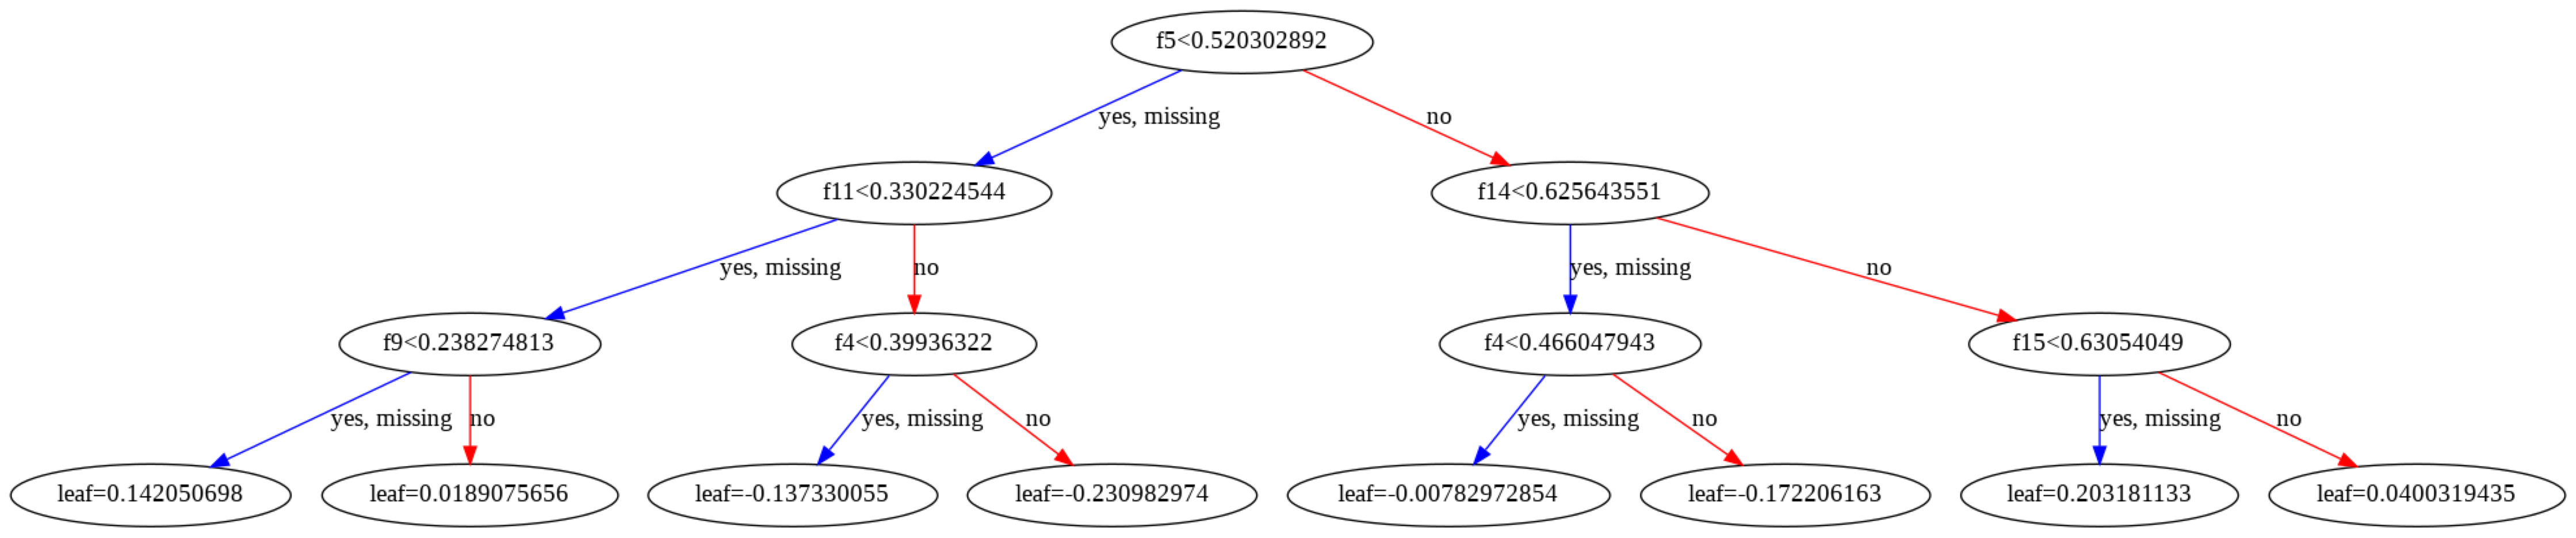

<class 'matplotlib.axes._subplots.AxesSubplot'>


In [ ]:
rcParams['figure.figsize'] = 80,50
a = xgb.plot_tree(model)
plt.show()
print(type(a))
plt.show(a)

## Meat of Phase 3:
Now make a Neural Network to do the work rather than a single sigmoid function. Still have the sigmoid at the end for classification, but make a set of neurons initially.


In [ ]:

def PlotHistory(His,title):
    loss = His.history['loss']
    train_acc = His.history['acc']
    val_acc = His.history['val_acc']

    plt.plot(train_acc,'bo',label='Training Accuracy')
    plt.plot(val_acc,'ro',label='Validation Accuracy')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([.60,1.00])
    plt.legend()
    plt.show()

def GetKeysPrecision(His):
    train_key = ''
    val_key = ''
    for key in His.history.keys():
        if 'prec' in key:
            if 'val' in key:
                val_key = key
            else:
                train_key = key
    return train_key,val_key

def GetKeys(His): #Accuracy
    train_key = ''
    val_key = ''
    for key in His.history.keys():
        if 'acc' in key:
            if 'val' in key:
                val_key = key
            else:
                train_key = key
    return train_key,val_key

def GetBestPrecision(His):
    train_key,val_key = GetKeysPrecision(His)
    return max(His.history[train_key]),max(His.history[val_key])

def GetBest(His):
    train_key,val_key = GetKeys(His)
    return max(His.history[train_key]),max(His.history[val_key])
    
def PlotPrecision(His,title):
    train_key,val_key = GetKeysPrecision(His)
            
    
    train_prec = His.history[train_key]
    val_prec = His.history[val_key]

    plt.plot(val_prec,'ro',label='Validation Precision')
    plt.plot(train_prec,'bo',label='Training Precision')

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.ylim([.60,1.00])
    plt.legend()
    plt.show()

def PlotRecall(His,title):
    train_key = ''
    val_key = ''
    for key in His.history.keys():
        if 'recall' in key:
            if 'val' in key:
                val_key = key
            else:
                train_key = key
    
    train_recall = His.history[train_key]
    val_recall = His.history[val_key]

    plt.plot(val_recall,'ro',label='Validation Recall')
    plt.plot(train_recall,'bo',label='Training Recall')

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.ylim([.60,1.00])
    plt.legend()
    plt.show()

    
def PlotFeatureImportance(TrAcc,VaAcc,title="Feature Importance (Training Accuracy)",baseline=0.5,col='orange',tcol='red'):
    tr = [a for a,b in TrAcc]
    ti = [10*b for a,b in TrAcc]
    a,b = rcParams['figure.figsize']
    plt.barh(ti,tr,height=5,color=col,tick_label=ColNames,label='Training Accuracy')
    plt.title(title)
    plt.xlim([0.5, 0.8])
    plt.plot([baseline,baseline],[ti[0],ti[-1]],color=tcol,linewidth=a/4,label='Baseline Accuracy')
    plt.legend(loc='upper right')
    plt.show()

def PlotFeatureImportanceVert(TrAcc,VaAcc,title="Feature Importance (Training Accuracy)",baseline=0.5,col='orange',tcol='red'):
    tr = [a for a,b in TrAcc]
    ti = [10*b for a,b in TrAcc]
    a,b = rcParams['figure.figsize']
    plt.bar(ti,tr,width=5,color=col,tick_label=ColNames,label='Training Accuracy')
    plt.title(title)
    plt.ylim([0.5, 0.8])
    plt.plot([ti[0],ti[-1]],[baseline,baseline],color=tcol,linewidth=b/4,label='Baseline Accuracy')
    plt.legend(loc='upper right')
    plt.xticks(rotation=90)
    plt.show()    
    
def PlotDecreasingFeatures(TrAcc,title="Reducing Features Accuracy",baseline=0.5,col='orange',tcol='red'):
    tr = [a for a,b in TrAcc]
    ti = [10*a for a in range(len(TrAcc))]
    ReducingNames = ["Full Features"]
    for i in range(1,len(TrAcc)):
        ReducingNames.append(f"{i} Removed")
    a,b = rcParams['figure.figsize']
    plt.bar(ti,tr,width=5,color=col,tick_label=ReducingNames,label='Training Accuracy')
    plt.title(title)
    plt.ylim([0.5, 0.9])
    plt.plot([ti[0],ti[-1]],[baseline,baseline],color=tcol,linewidth=b/4,label='Baseline Accuracy')
    plt.legend(loc='upper right')
    plt.xticks(rotation=80)
    plt.show()    
    

## Phase 4 - Feature Elimination



In [ ]:
xtrain = XTRAIN[:,0:1]
#Create a single-input model of the 'optimal' size found in phase 3
modelOneRELU = Sequential()
modelOneRELU.add(Dense(75,input_dim=len(xtrain[0,:]),activation='relu'))
modelOneRELU.add(Dense(75,activation='relu'))
#modelOneRELU.add(Dense(2,activation='relu'))
#modelOneRELU.add(Dense(10,activation='relu'))
modelOneRELU.add(Dense(1,activation='sigmoid'))

modelOneRELU.compile(loss='binary_crossentropy',optimizer='rmsprop',
                     metrics = ['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(modelOneRELU.summary())
modelOneRELU.save_weights('OneInputInitialWeights.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 75)                150       
                                                                 
 dense_1 (Dense)             (None, 75)                5700      
                                                                 
 dense_2 (Dense)             (None, 1)                 76        
                                                                 
Total params: 5,926
Trainable params: 5,926
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#TimesNowData = np.genfromtxt("TIMESNOW.csv",delimiter=",",skip_header=True,usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))


#Train the model across all features:
histories = []
MaxTrain = []
MaxValid = []
xtrain = XTRAIN[:,0:1]
xvalid = XVALID[:,0:1]
print (xtrain.shape)
for i in range(len(XTRAIN[0,:])):
    modelOneRELU.load_weights('OneInputInitialWeights.h5')
    %time HistoryTwoRELU = modelOneRELU.fit(x = XTRAIN[:,i:i+1],y = YTRAIN,epochs = 50,verbose = 0,batch_size=512,validation_data=(XVALID[:,i:i+1],YVALID))
    histories.append((i,HistoryTwoRELU))
    max_train_acc,max_val_acc =  GetBestPrecision(HistoryTwoRELU)
    print (f"Feature {i} train: {max_train_acc}, validation: {max_val_acc}")
    MaxTrain.append((max_train_acc,i))
    MaxValid.append((max_val_acc,i))

    

(90780, 1)
CPU times: user 1min 24s, sys: 11.6 s, total: 1min 36s
Wall time: 1min 23s
Feature 0 train: 0.64537113904953, validation: 0.6476988792419434
CPU times: user 1min 23s, sys: 11.3 s, total: 1min 34s
Wall time: 1min 21s
Feature 1 train: 0.6445174813270569, validation: 0.6525003910064697
CPU times: user 1min 22s, sys: 11.6 s, total: 1min 34s
Wall time: 1min 21s
Feature 2 train: 0.6460096836090088, validation: 0.6486833691596985
CPU times: user 1min 24s, sys: 11.3 s, total: 1min 36s
Wall time: 1min 21s
Feature 3 train: 0.6449715495109558, validation: 0.644707202911377
CPU times: user 1min 21s, sys: 11.6 s, total: 1min 33s
Wall time: 1min 21s
Feature 4 train: 0.6447599530220032, validation: 0.6805296540260315
CPU times: user 1min 23s, sys: 11.3 s, total: 1min 35s
Wall time: 1min 21s
Feature 5 train: 0.7681494951248169, validation: 0.7951311469078064
CPU times: user 1min 23s, sys: 11.5 s, total: 1min 34s
Wall time: 1min 2s
Feature 6 train: 0.6459347605705261, validation: 0.647500753

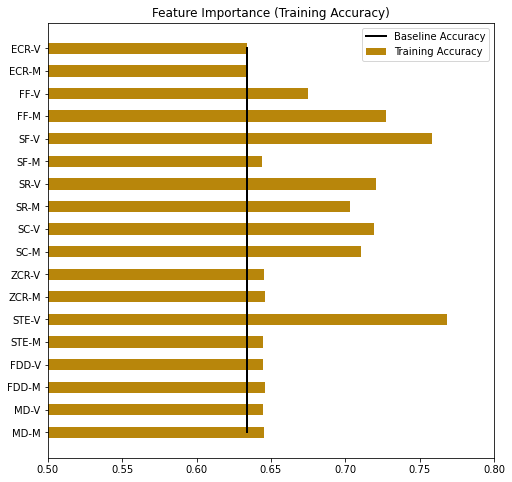

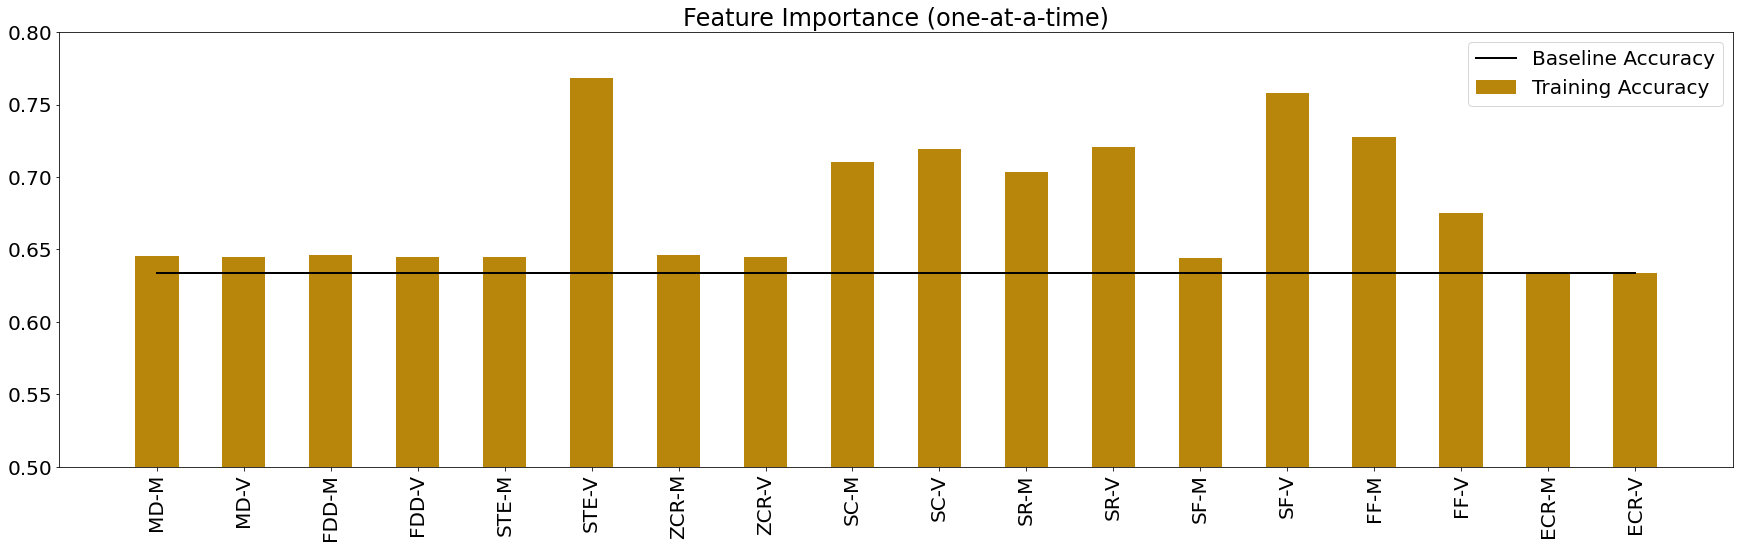

In [ ]:
#0.6166480645324945 positives in the training data set
#0.6229061852619118 positives in the validation data set
#0.634 positives in the full training set.
from matplotlib.pylab import rcParams
rcParams['font.size'] = 10.0
rcParams['figure.figsize'] = 8,8
#print (rcParams.keys())
PlotFeatureImportance(MaxTrain,MaxValid,baseline=0.634,col='darkgoldenrod',tcol='black')
rcParams['font.size'] = 20.0
rcParams['figure.figsize'] = 30,8
PlotFeatureImportanceVert(MaxTrain,MaxValid,baseline=0.634,col='darkgoldenrod',tcol='black',title='Feature Importance (one-at-a-time)')


In [ ]:
MaxTrainSorted = MaxTrain[:]
MaxTrainSorted.sort()
MaxValidSorted = MaxValid[:]
MaxValidSorted.sort()

Order = [b for a,b in MaxTrainSorted]
print(Order)

[16, 17, 12, 1, 4, 3, 7, 0, 6, 2, 15, 10, 8, 9, 11, 14, 13, 5]


In [ ]:
print(XTRAIN.shape)
print (XTRAIN[:,0:1].shape)

(90780, 18)
(90780, 1)


### Now make the case that shows how much affect on the model resonse removing individual features has

The features will be removed in the following order:
1) Feature 16, ECR-M<br>
2) Feature 17, ECR-V<br>
3) Feature 3 - FDD-V<br>
4) Feature 2 - FDD-M<br>
5) Feature 7 - ZCR-V<br>
6) Feature 0 - MD-M<br>
7) Feature 1 - MD-V<br>
8) Feature 12 - SF-M<br>
9) Feature 4 - STE-M<br>
10) Feature 6 - this is the one where it could get interesting<br>
11) Feature 15 - this might have a profound affect<br>

In [ ]:
Ranges = [np.r_[0:18],np.r_[0:16,17:18],np.r_[0:16],
          np.r_[0:3,4:16],np.r_[0:2,4:16],np.r_[0:2,4:7,8:16],
          np.r_[1:2,4:7,8:16],np.r_[4:7,8:16],np.r_[4:7,8:12,13:16],
          np.r_[5:7,8:12,13:16],np.r_[5:6,8:12,13:16],np.r_[5:6,8:12,13:15]]
#Ranges = [np.r_[0:18]]
MaxTr = []
MaxVa = []
ReducingHistories = []
for r in Ranges:
    xtrain = XTRAIN[:,r]
    print (f"Size of xtrain: {len(xtrain[0,:])}")
    xvalid = XVALID[:,r]
    modelRELU = Sequential()
    modelRELU.add(Dense(75,input_dim=len(xtrain[0, :]),activation='relu'))
    modelRELU.add(Dense(75,activation='relu'))
    modelRELU.add(Dense(1,activation='sigmoid'))
    modelRELU.compile(loss='binary_crossentropy',optimizer='rmsprop',
                     metrics = ['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    print(modelRELU.summary())
    %time HistoryRELU = modelRELU.fit(x = xtrain,y = YTRAIN,epochs = 50,verbose = 0,batch_size=512,validation_data=(xvalid,YVALID))
    ReducingHistories.append(HistoryRELU)
    max_train_acc,max_val_acc =  GetBest(HistoryRELU)
    print (f"Features: {len(r)} train: {max_train_acc}, validation: {max_val_acc}")
    MaxTr.append((max_train_acc,len(xtrain[0,:])))
    MaxVa.append((max_val_acc,len(xtrain[0,:])))

Size of xtrain: 18
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 75)                1425      
                                                                 
 dense_4 (Dense)             (None, 75)                5700      
                                                                 
 dense_5 (Dense)             (None, 1)                 76        
                                                                 
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 1min 28s, sys: 11.5 s, total: 1min 39s
Wall time: 1min 23s
Features: 18 train: 0.8449438214302063, validation: 0.8493766784667969
Size of xtrain: 17
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Sha

[(0.8449438214302063, 18), (0.8462547063827515, 17), (0.8492839932441711, 16), (0.8436329364776611, 15), (0.8314937353134155, 14), (0.8297312259674072, 13), (0.8252148032188416, 12), (0.8239149451255798, 11), (0.8213152885437012, 10), (0.8018506169319153, 9), (0.7976866960525513, 8), (0.7921348214149475, 7)]


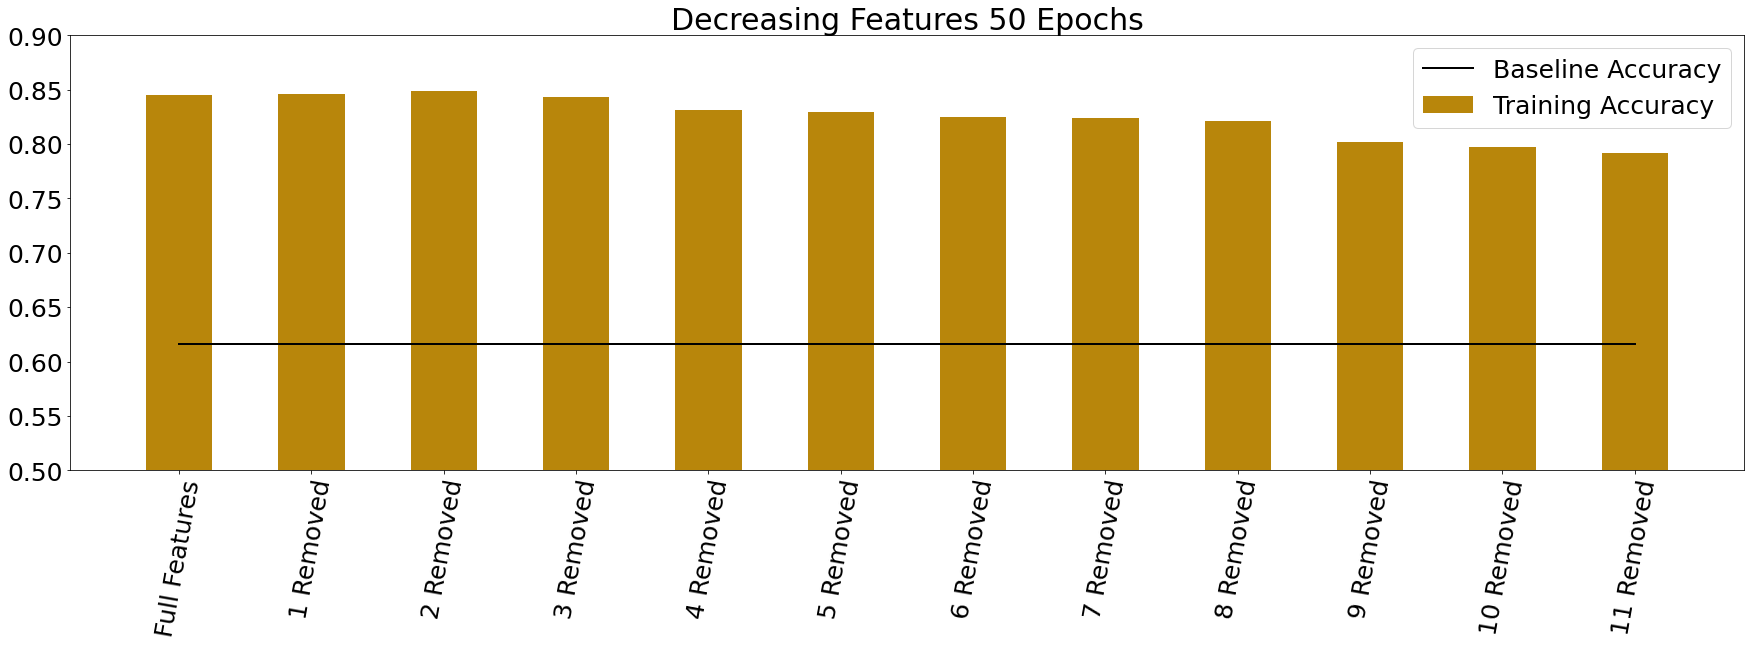

In [ ]:
print(MaxTr)
rcParams['font.size'] = 25.0
rcParams['figure.figsize'] = 30,8
PlotDecreasingFeatures(MaxTr,baseline=0.6166,col='darkgoldenrod',tcol='black',title='Decreasing Features 50 Epochs')


In [ ]:
Ranges = [np.r_[0:18],np.r_[0:16,17:18],np.r_[0:16],
          np.r_[0:3,4:16],np.r_[0:2,4:16],np.r_[0:2,4:7,8:16],
          np.r_[1:2,4:7,8:16],np.r_[4:7,8:16],np.r_[4:7,8:12,13:16],
          np.r_[5:7,8:12,13:16],np.r_[5:6,8:12,13:16],np.r_[5:6,8:12,13:15]]
for a in Ranges:
    print(a)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  4  5  6  8  9 10 11 12 13 14 15]
[ 1  4  5  6  8  9 10 11 12 13 14 15]
[ 4  5  6  8  9 10 11 12 13 14 15]
[ 4  5  6  8  9 10 11 13 14 15]
[ 5  6  8  9 10 11 13 14 15]
[ 5  8  9 10 11 13 14 15]
[ 5  8  9 10 11 13 14]


In [ ]:
modelOneRELU = Sequential()
modelOneRELU.add(Dense(75,input_dim=len(XTRAIN[0, :]),activation='relu'))
modelOneRELU.add(Dense(75,activation='relu'))
#modelOneRELU.add(Dense(2,activation='relu'))
#modelOneRELU.add(Dense(10,activation='relu'))
modelOneRELU.add(Dense(1,activation='sigmoid'))

modelOneRELU.compile(loss='binary_crossentropy',optimizer='rmsprop',
                     metrics = ['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(modelOneRELU.summary())

%time HistoryTwoRELU = modelOneRELU.fit(x = XTRAIN,y = YTRAIN,epochs = 500,verbose = 2,batch_size=512,validation_data=(XVALID,YVALID))

Epoch 1/500


ValueError: ignored

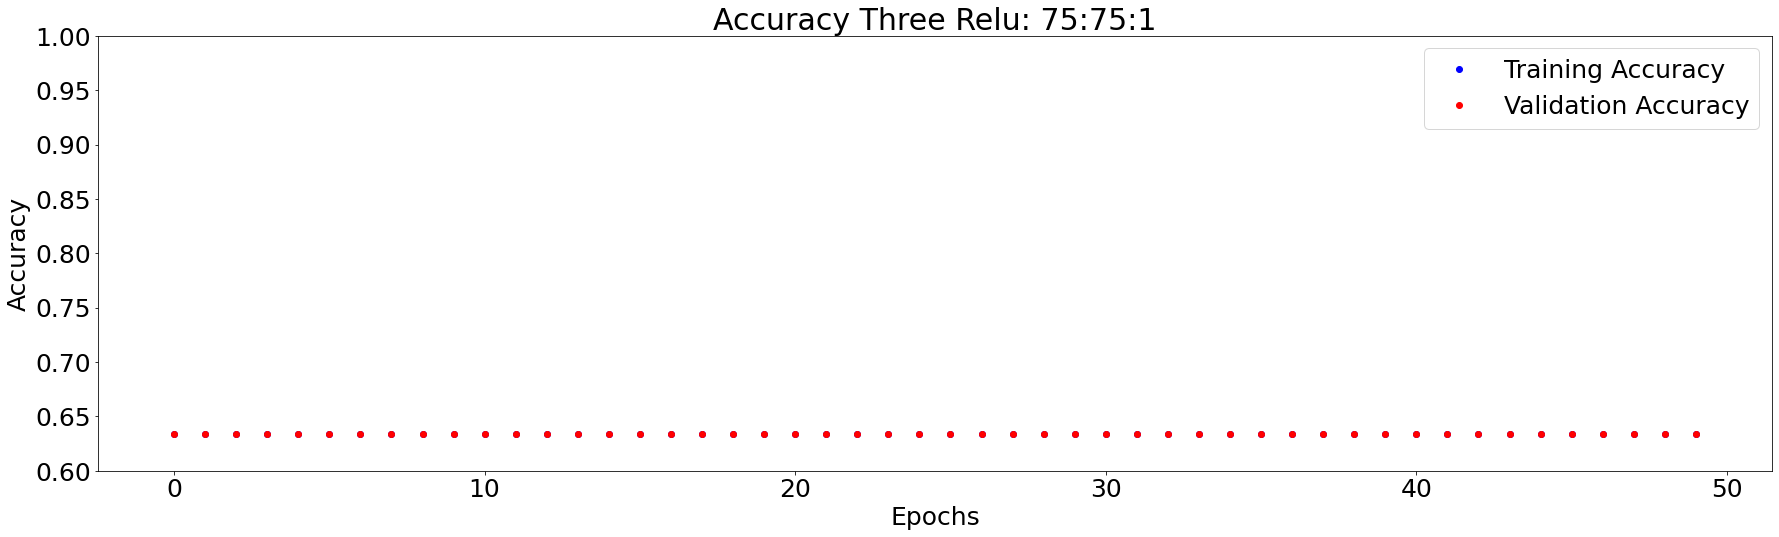

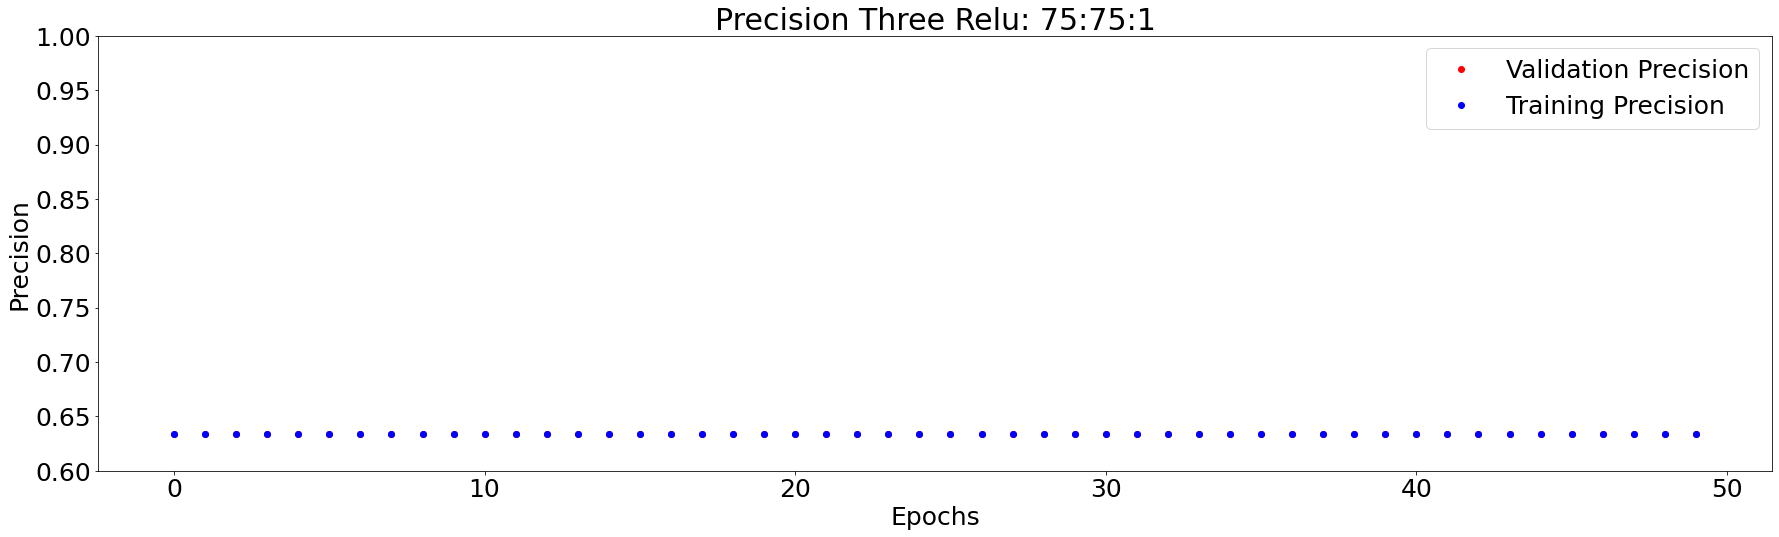

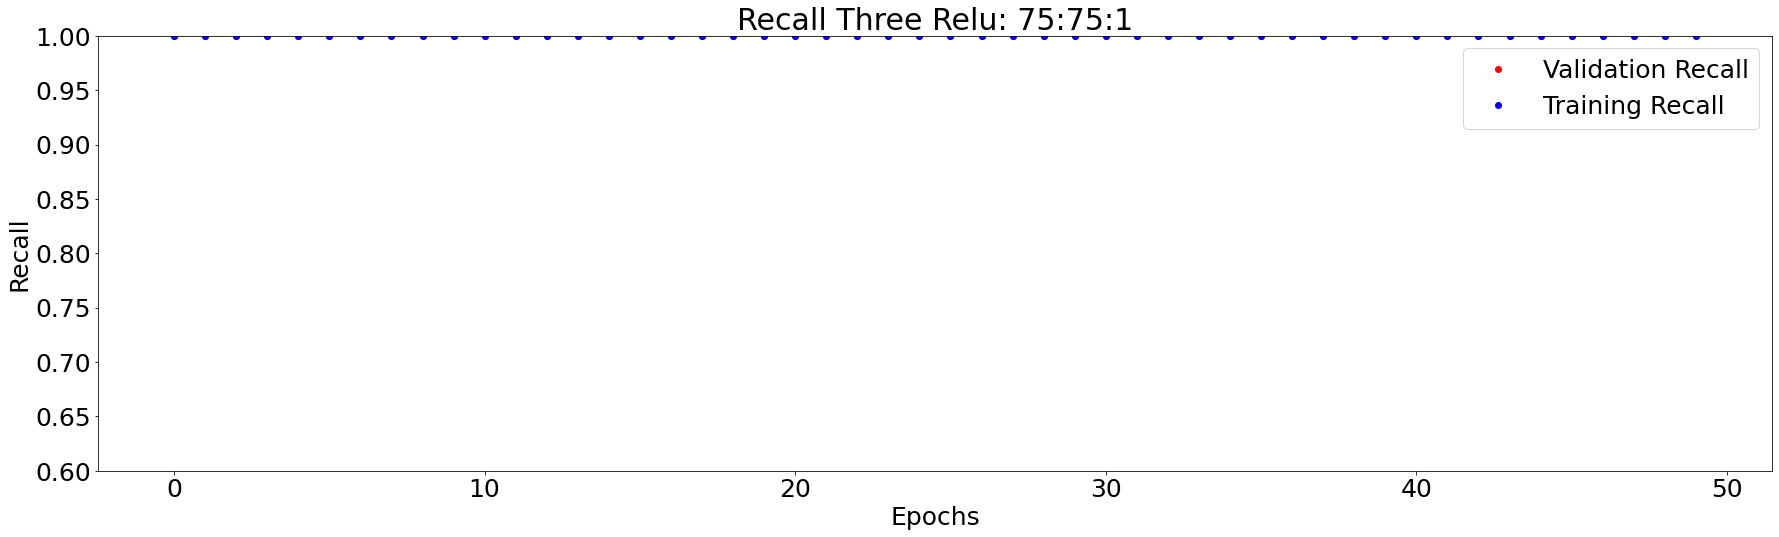

In [ ]:
PlotHistory(HistoryTwoRELU,"Accuracy Three Relu: 75:75:1")
PlotPrecision(HistoryTwoRELU,"Precision Three Relu: 75:75:1")
PlotRecall(HistoryTwoRELU,"Recall Three Relu: 75:75:1")


## Early Stopping - Phase 4 - using reduced set of features

In [ ]:
import keras
ReducedSet = np.r_[5:7,8:12,13:16]
ReducedSet = np.r_[0:2,4:7,8:16] # 6 features removed
xtrain = XTRAIN[:,ReducedSet]
print (f"Size of xtrain: {len(xtrain[0,:])}")
xvalid = XVALID[:,ReducedSet]
modelRELUEarly = Sequential()
modelRELUEarly.add(Dense(75,input_dim=len(xtrain[0, :]),activation='relu'))
modelRELUEarly.add(Dense(75,activation='relu'))
modelRELUEarly.add(Dense(1,activation='sigmoid'))
modelRELUEarly.compile(loss='binary_crossentropy',optimizer='rmsprop',
                     metrics = ['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(modelRELUEarly.summary())
modelRELUEarly.compile(loss='binary_crossentropy',optimizer='rmsprop',
                     metrics = ['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=200),
            keras.callbacks.ModelCheckpoint(filepath='BestAdsReduced.h5',monitor='val_loss',save_best_only=True)]
%time HistoryReducedRELU = modelRELUEarly.fit(x = xtrain,y = YTRAIN, callbacks = callback_list, epochs = 10000,verbose = 2,batch_size=512,validation_data=(xvalid,YVALID))

Size of xtrain: 13
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 75)                1050      
                                                                 
 dense_40 (Dense)            (None, 75)                5700      
                                                                 
 dense_41 (Dense)            (None, 1)                 76        
                                                                 
Total params: 6,826
Trainable params: 6,826
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10000
178/178 - 3s - loss: 0.5317 - acc: 0.7436 - precision_14: 0.7469 - recall_14: 0.9010 - val_loss: 0.4637 - val_acc: 0.7932 - val_precision_14: 0.8171 - val_recall_14: 0.8681 - 3s/epoch - 16ms/step
Epoch 2/10000
178/178 - 1s - loss: 0.4599 - acc: 0.7929 - precision_14: 0.8123 - 

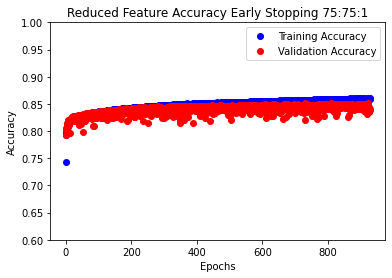

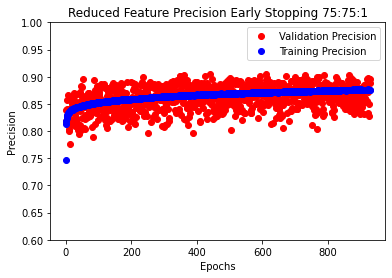

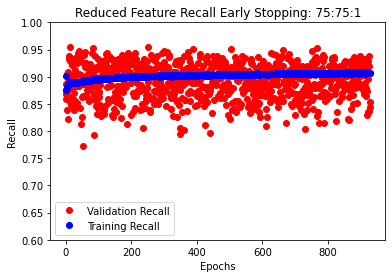

In [ ]:
rcParams['figure.figsize'] = 6.0,4.0
rcParams['font.size'] = 10.0
PlotHistory(HistoryReducedRELU,"Reduced Feature Accuracy Early Stopping 75:75:1")
PlotPrecision(HistoryReducedRELU,"Reduced Feature Precision Early Stopping 75:75:1")
PlotRecall(HistoryReducedRELU,"Reduced Feature Recall Early Stopping: 75:75:1")

In [ ]:
import keras
print (f"Size of XTRAIN: {len(XTRAIN[0,:])}")
modelFullEarly = Sequential()
modelFullEarly.add(Dense(75,input_dim=len(XTRAIN[0, :]),activation='relu'))
modelFullEarly.add(Dense(75,activation='relu'))
modelFullEarly.add(Dense(1,activation='sigmoid'))
modelFullEarly.compile(loss='binary_crossentropy',optimizer='rmsprop',
                     metrics = ['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(modelFullEarly.summary())
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=200),
            keras.callbacks.ModelCheckpoint(filepath='BestAdsFull.h5',monitor='val_loss',save_best_only=True)]
%time HistoryFullRELU = modelFullEarly.fit(x = XTRAIN,y = YTRAIN, callbacks = callback_list, epochs = 10000,verbose = 2,batch_size=512,validation_data=(XVALID,YVALID))


Size of XTRAIN: 18
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 75)                1425      
                                                                 
 dense_43 (Dense)            (None, 75)                5700      
                                                                 
 dense_44 (Dense)            (None, 1)                 76        
                                                                 
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10000
178/178 - 3s - loss: 0.5113 - acc: 0.7593 - precision_15: 0.7657 - recall_15: 0.8939 - val_loss: 0.4670 - val_acc: 0.7857 - val_precision_15: 0.7719 - val_recall_15: 0.9398 - 3s/epoch - 16ms/step
Epoch 2/10000
178/178 - 1s - loss: 0.4457 - acc: 0.8003 - precision_15: 0.8201 - 

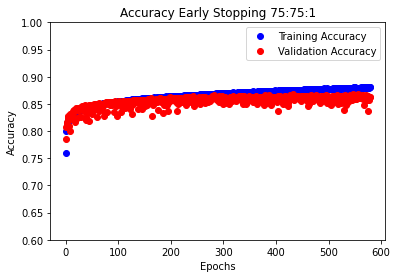

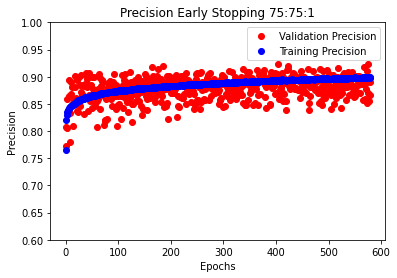

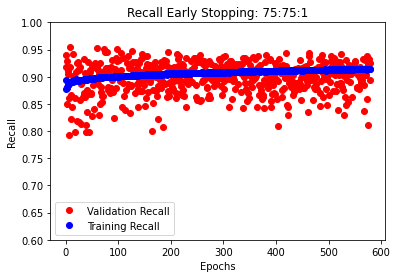

In [ ]:
PlotHistory(HistoryFullRELU,"Accuracy Early Stopping 75:75:1")
PlotPrecision(HistoryFullRELU,"Precision Early Stopping 75:75:1")
PlotRecall(HistoryFullRELU,"Recall Early Stopping: 75:75:1")

In [ ]:
modelRELUEarly.load_weights('BestAdsReduced.h5')
modelFullEarly.load_weights('BestAdsFull.h5')
accuracyReduced = modelRELUEarly.evaluate(xvalid, YVALID) #reduced feature set
accuracyFull = modelFullEarly.evaluate(XVALID, YVALID) #Full feature set
print (f"Full Feature Set Accuracy: {accuracyFull[1]}")
print (f"Reduced Feature Set Accuracy: {accuracyReduced[1]}")
acc_diff = accuracyFull[1] - accuracyReduced[1]
print (f"Difference: {acc_diff}; (negative indicates Reduced set has better accuracy)")

1216/1216 [==============================] - 6s 5ms/step - loss: 0.3337 - acc: 0.8658 - precision_15: 0.8849 - recall_15: 0.9063
Full Feature Set Accuracy: 0.8658270239830017
Reduced Feature Set Accuracy: 0.8518956303596497
Difference: 0.01393139362335205; (negative indicates Reduced set has better accuracy)


In [ ]:
#### print(modelRELUEarly.metrics_names)
print(modelFullEarly.metrics_names)
    

['loss', 'acc', 'precision_15', 'recall_15']


![image.png](attachment:image.png)

![image.png](attachment:image.png)

This file is licensed under the Creative Commons Attribution-Share Alike 4.0 International license. 
From Wikipedia